In [1]:
# Importando as bibliotecas necessárias
!pip install seaborn
import os
import pandas as pd
from IPython.display import Image, display
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Variáveis Constantes e Conexão com o Banco de Dados
BASE_PATH = '../../Dataset-1'
DB_PATH = 'db.sqlite3'
conn = sqlite3.connect('db.sqlite3')

DEPRECATION: Loading egg at c:\users\erick bryan\appdata\local\programs\python\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
files = os.listdir(BASE_PATH)
print("Arquivos no diretório Dataset-1:")
print(files)

Arquivos no diretório Dataset-1:
['Calendar.csv', 'Custumers.csv', 'Product.csv', 'Sales.csv', 'Territory.csv']


In [3]:
# Função para carregar os dados
def load_data(file_name):
    return pd.read_csv(os.path.join(BASE_PATH, file_name), encoding='latin1')

# Carregando os dados
calendar = load_data('Calendar.csv')
customers = load_data('Custumers.csv')
product = load_data('Product.csv')
sales = load_data('Sales.csv')
territory = load_data('Territory.csv')

print("Calendar:")
print(calendar.head())
print("\nCustomers:")
print(customers.head())
print("\nProduct:")
print(product.head())
print("\nSales:")
print(sales.head())
print("\nTerritory:")
print(territory.head())

Calendar:
          Date   DateKey  Year Quarter  MonthNum Month FiscalYear  \
0  4/3/16 0:00  20160403  2016      Q2         4   Apr     FY2016   
1  4/4/16 0:00  20160404  2016      Q2         4   Apr     FY2016   
2  4/5/16 0:00  20160405  2016      Q2         4   Apr     FY2016   
3  4/6/16 0:00  20160406  2016      Q2         4   Apr     FY2016   
4  4/7/16 0:00  20160407  2016      Q2         4   Apr     FY2016   

  FiscalQuarter  FiscalMonthNum FiscalMonth MonthYear MonthYearLong  \
0           FQ4              10         Apr    Apr-16      Apr-2016   
1           FQ4              10         Apr    Apr-16      Apr-2016   
2           FQ4              10         Apr    Apr-16      Apr-2016   
3           FQ4              10         Apr    Apr-16      Apr-2016   
4           FQ4              10         Apr    Apr-16      Apr-2016   

   MonthYearNum  WeekdayNum Weekday WeekdayWeekend  
0        201604           1     Sun        Weekend  
1        201604           2     Mon       

C:\Users\Erick Bryan\AppData\Local\Temp\ipykernel_24504\4049932928.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(os.path.join(BASE_PATH, file_name), encoding='latin1')


# Questão 1: Explicação das Tabelas e Relações
### Tabela Calendar
A tabela *Calendar* contém informações de datas, incluindo chave de data (DateKey), ano, trimestre, mês, e detalhes fiscais. A tabela não calendário não se relaciona diretamente com as outras tabelas, mas pode ser usada para criar relações indiretas com base em datas.

### Tabela Customers
A tabela *Customers* contém informações sobre os clientes, incluindo chave do cliente (CustomerKey), nome, data de nascimento, estado civil, gênero, renda anual, entre outros detalhes demográficos, que podem ser usados para segmentar os clientes e analisar o comportamento de compra.

### Tabela Product
A tabela Product fornece detalhes dos produtos, como chave do produto (ProductKey), nome do produto, subcategoria, categoria, custo padrão, cor, preço de lista, entre outros.

### Tabela Sales
A tabela Sales registra as vendas realizadas, incluindo chave do produto (ProductKey), data do pedido (OrderDate), data de envio (ShipDate), chave do cliente (CustomerKey), chave da promoção (PromotionKey), quantidade do pedido (OrderQuantity), preço unitário (UnitPrice), e várias colunas adicionais que parecem estar desordenadas ou desnecessárias.

### Tabela Territory
A tabela Territory contém informações sobre as regiões de vendas, incluindo chave do território de vendas (SalesTerritoryKey), região, país, grupo, e uma imagem da região (RegionImage).

## Relações entre as Tabelas
A tabela Sales está relacionada à Product através de ProductKey: N:1 (muitas vendas para um produto).
A tabela Sales está relacionada à Customers através de CustomerKey: N:1 (muitas vendas para um cliente).
A tabela Customers está relacionada à Territory através de SalesTerritoryKey: N:1 (muitos clientes para um território).


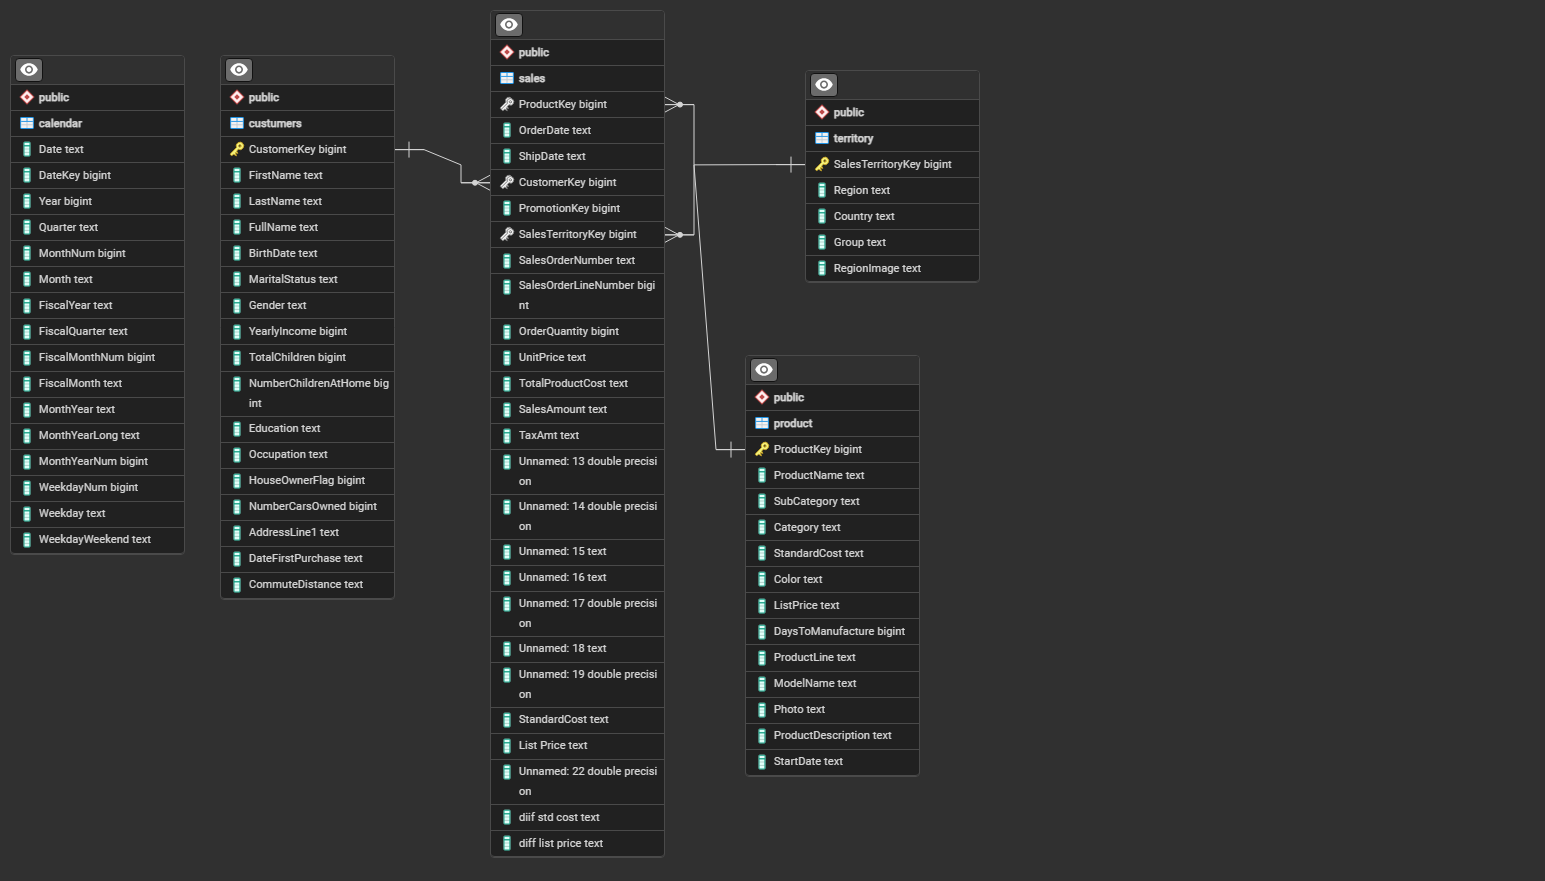

In [4]:
image_path = "../../docs/Entity-Relationship Diagram/ERD-for-schema-dataset-1.pgerd.png"
display(Image(filename=image_path))

In [5]:
# Exibindo colunas dos datasets
datasets = {'calendar': calendar, 'customers': customers, 'product': product, 'sales': sales, 'territory': territory}
for name, df in datasets.items():
    print(f"\nColunas de {name}:")
    print(df.columns)

# Tratativa de valores inválidos ou inconsistentes
sales.dropna(axis=1, how='all', inplace=True)
sales.drop(columns=['List Price', 'StandardCost', 'diif std cost', 'diff list price'], inplace=True)

# Transformando colunas de string para numérico
columns_to_convert = ['TotalProductCost', 'SalesAmount', 'TaxAmt', 'UnitPrice']
for col in columns_to_convert:
    sales[col] = pd.to_numeric(sales[col].str.replace(',', '.'), errors='coerce')
    print(f"Tipos de dados da coluna {col}: {sales[col].dtype}")

# Conectando ao banco de dados SQLite
conn = sqlite3.connect(DB_PATH)

# Salvando dados no banco de dados
calendar.to_sql('calendar', conn, if_exists='replace', index=False)
customers.to_sql('custumers', conn, if_exists='replace', index=False)  # Nome da tabela corrigido
product.to_sql('product', conn, if_exists='replace', index=False)
sales.to_sql('sales', conn, if_exists='replace', index=False)
territory.to_sql('territory', conn, if_exists='replace', index=False)

# Exibindo as tabelas no banco de dados
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("\nTabelas no banco de dados:")
print(tables)

# Exibindo esquema da tabela Sales
schema = pd.read_sql_query("PRAGMA table_info(sales);", conn)
print("\nEsquema da tabela Sales:")
print(schema)

# Exibindo as primeiras linhas da tabela Sales
sales_check = pd.read_sql_query("SELECT * FROM sales LIMIT 5;", conn)
print("\nPrimeiras linhas da tabela Sales:")
print(sales_check)

# Verificando valores inválidos ou inconsistentes na tabela Sales
invalid_values_check = sales.isnull().sum()
print("\nValores inválidos ou inconsistentes na tabela Sales:")
print(invalid_values_check)

# Exibindo os tipos de dados das colunas na tabela Sales
print("\nTipos de dados das colunas na tabela Sales:")
print(sales.dtypes)

# Exibindo novamente as primeiras linhas da tabela Sales
sales_check = pd.read_sql_query("SELECT * FROM sales LIMIT 5;", conn)
print("\nPrimeiras linhas da tabela Sales:")
print(sales_check)


Colunas de calendar:
Index(['Date', 'DateKey', 'Year', 'Quarter', 'MonthNum', 'Month', 'FiscalYear',
       'FiscalQuarter', 'FiscalMonthNum', 'FiscalMonth', 'MonthYear',
       'MonthYearLong', 'MonthYearNum', 'WeekdayNum', 'Weekday',
       'WeekdayWeekend'],
      dtype='object')

Colunas de customers:
Index(['CustomerKey', 'FirstName', 'LastName', 'FullName', 'BirthDate',
       'MaritalStatus', 'Gender', 'YearlyIncome', 'TotalChildren',
       'NumberChildrenAtHome', 'Education', 'Occupation', 'HouseOwnerFlag',
       'NumberCarsOwned', 'AddressLine1', 'DateFirstPurchase',
       'CommuteDistance'],
      dtype='object')

Colunas de product:
Index(['ProductKey', 'ProductName', 'SubCategory', 'Category', 'StandardCost',
       'Color', 'ListPrice', 'DaysToManufacture', 'ProductLine', 'ModelName',
       'Photo', 'ProductDescription', 'StartDate'],
      dtype='object')

Colunas de sales:
Index(['ProductKey', 'OrderDate', 'ShipDate', 'CustomerKey', 'PromotionKey',
       'SalesTerr

# Questão 2: Três Produtos Mais Vendidos em Termos de Quantidade

Para encontrar os três produtos mais vendidos em termos de quantidade, podemos agrupar os dados da tabela Sales por ProductKey e somar a quantidade de pedidos (OrderQuantity) para cada produto. Em seguida, podemos classificar os produtos com base na quantidade total de pedidos em ordem decrescente e selecionar os três primeiros produtos.
Segue o código para encontrar os três produtos mais vendidos em termos de quantidade:

No SQLite:
```sql
SELECT 
Sales.ProductKey AS ProductKey,
Product.ProductName AS Product,
SUM(OrderQuantity) AS TotalQuantity
FROM Sales
INNER JOIN Product ON Product.ProductKey = Sales.ProductKey
GROUP BY Sales.ProductKey, Product.ProductName 
ORDER BY TotalQuantity DESC
LIMIT 3;
```

No PostgreSQL:
```sql
SELECT
Sales."ProductKey" AS ProductKey,
Product."ProductName" AS Product,
SUM("OrderQuantity") AS TotalQuantity
FROM Sales
INNER JOIN Product ON Product."ProductKey" = Sales."ProductKey"
GROUP BY Sales."ProductKey", Product."ProductName"
ORDER BY TotalQuantity DESC
LIMIT 3;
```

In [6]:
query = """
SELECT Sales.ProductKey AS ProductKey, Product.ProductName AS Product, SUM(OrderQuantity) AS TotalQuantity
FROM Sales
INNER JOIN Product ON Product.ProductKey = Sales.ProductKey
GROUP BY Sales.ProductKey, Product.ProductName 
ORDER BY TotalQuantity DESC
LIMIT 3;
"""

top_products = pd.read_sql_query(query, conn)
print("Três produtos mais vendidos em termos de quantidade:")
print(top_products)

Três produtos mais vendidos em termos de quantidade:
   ProductKey                Product  TotalQuantity
0         477  Water Bottle - 30 oz.           6370
1         480    Patch Kit/8 Patches           4705
2         528     Mountain Tire Tube           4551


# Questão 3: Lucro Total por Região

Para calcular o lucro total por região, podemos usar a tabela Sales para obter o lucro total de cada venda, que é calculado como a diferença entre o TotalProductCost e SalesAmount. Em seguida, podemos agrupar os dados por região (Region) e somar o lucro total de todas as vendas em cada região.

Segue o código para calcular o lucro total por região:

No SQLite:
```sql
SELECT
    t."Region",
    ROUND(SUM(s."SalesAmount" - s."TotalProductCost"), 2) AS TotalProfit
FROM
    sales s
JOIN
    territory t ON s."SalesTerritoryKey" = t."SalesTerritoryKey"
GROUP BY
    t."Region"
ORDER BY
    TotalProfit DESC;
```

No PostgreSQL:
```sql
SELECT
    t."Region",
    to_char(SUM(s."SalesAmount" - s."TotalProductCost"), 'FM999999999.00') AS TotalProfit
FROM
    sales s
JOIN
    territory t ON s."SalesTerritoryKey" = t."SalesTerritoryKey"
GROUP BY
    t."Region"
ORDER BY
    SUM(s."SalesAmount" - s."TotalProductCost") DESC;
```

In [7]:
# Consulta SQL para calcular o lucro total por região e formatar os valores com duas casas decimais
query = """
SELECT
    t."Region",
    ROUND(SUM(s."SalesAmount" - s."TotalProductCost"), 2) AS TotalProfit
FROM
    sales s
JOIN
    territory t ON s."SalesTerritoryKey" = t."SalesTerritoryKey"
GROUP BY
    t."Region"
ORDER BY
    TotalProfit DESC;
"""

# Executar a consulta e obter os resultados
total_profit_by_region = pd.read_sql_query(query, conn)
print("Lucro total por região:")
print(total_profit_by_region)

Lucro total por região:
           Region  TotalProfit
0       Australia   3680840.92
1       Southwest   2366675.10
2       Northwest   1513988.79
3  United Kingdom   1388156.97
4         Germany   1185283.98
5          France   1084258.08
6          Canada    823799.32
7       Southeast      5261.09
8       Northeast      2902.76
9         Central      1350.92


# Questão 4: Processo ETL

Vou segmentar a ETL em duas frentes, uma para serviços web e outra para fins de análise de dados.

ETL (Extract, Transform, Load):

## Extract:
O primeiro passso é identificar as fontes de dados das quais vamos extrair informações. No caso, as fontes de dados são os sistemas legados que contêm informações sobre vendas, clientes, produtos e territórios. Podem ser usadas consultas SQL ou APIs para extrair os dados necessários.

##### <span style="color:red;">Serviços Web:</span>
Conectar a fonte de dados utilizando APIs RESTful Flask, Django ou FastAPI. Ou seja, construimos uma API para extrair dados para o data warehouse. Essa alternativa é mais segura e escalável, pois permite controlar o acesso aos dados e limitar as consultas.

##### <span style="color:red;">Análise de Dados:</span>
Utilizar consultas SQL para extrair os dados diretamente dos sistemas legados. Ou consultas com Python utilizando bibliotecas como Requests e Pandas para extrair os dados e transformá-los em DataFrames:
    
- 1º Alternativa (Escalável): Podemos criar imagens Docker para executar os scripts de extração e transformação dos dados. Essas imagens podem ser executadas em contêineres Docker e agendadas para rodar periodicamente e atualizar o data warehouse. Elas são armazenadas em um repositório de contêineres como o ECR (AWS) ou Container Registry (GCP), e podem ser escaladas facilmente conforme a demanda de dados aumenta. Sua execução no ECS (AWS) ou Kubernetes (GCP) permite orquestrar a execução dos contêineres e monitorar o desempenho dos scripts.

- 2º Alternativa (Menos escalável e difícil de monitorar): Podemos utilizar instâncias EC2 (AWS) ou Compute Engine (GCP) para executar as consultas e extrair os dados: A execução dos scripts de extração podem ser agendados para rodar periodicamente e atualizar o data warehouse. Normalmente nesses casos, é necessário configurar um serviço de monitoramento para garantir que os scripts estão sendo executados corretamente e que os dados estão sendo extraídos e transformados conforme o esperado. Como DataDog, Prometheus, Grafana, etc. Ou uma forma simples de disparar alertas em e-mails com Python.

- 3º Alternativa (Fácil monitoramento): Podemos utilizar ferramentas de ETL como Apache NiFi extrair os dados dos sistemas legados e transformá-los em um formato adequado para o data warehouse. O Apache NiFi é uma ferramenta de código aberto que permite criar pipelines de dados visuais para mover, transformar e processar dados de forma eficiente. Ele pode ser executado em um cluster Hadoop ou em um servidor standalone, e oferece suporte a várias fontes de dados e destinos de dados. Uma das vantagens do Apache NiFi é a sua interface gráfica, que facilita a criação e o gerenciamento de pipelines de dados complexos.

## Transform:
O segundo passo é transformar os dados extraídos em um formato adequado para a análise. Isso pode envolver a limpeza dos dados, a padronização dos formatos, a agregação dos dados e a criação de novas colunas derivadas.

##### <span style="color:red;">Serviços Web:</span>
Como o foco está no serviço web, a transformação dos dados pode ser feita no backend da aplicação, as operaçõs de transformação podem ser feitas em tempo real, conforme os dados são recebidos pela API. Ou de forma assíncrona, utilizando filas de mensagens para processar os dados em lotes, caso a transformação seja mais complexa e demorada. Quando a tratativa é assicrona, podemos utilizar o Flask com Celery para processar os dados em segundo plano. O framework FastAPI também oferece suporte para tarefas assíncronas.

##### <span style="color:red;">Análise de Dados:</span>
Para fins análiticos, o foco está na tratativa dos dados para que possam ser carregados no data warehouse. Podemos utilizar Python ou GoLang, em python as seguintes bibliotecas são primordiais:
- Para transformação dos dados: Pandas, pandas_gbq, Modin, Numpy, Scikit-learn, etc;
- Para processamento dos dados:
    - Várias threads: threading, concurrent.futures, multiprocessing, queue;
    - Várias instâncias: Apache Spark, Apache Hadoop, Google Cloud Dataflow.
- Para monitoramento: logging;
- Para testes unitários: pytest.

GoLang utilizo quando preciso de mais performance, por exemplo, para processar grandes volumes de dados em tempo real. Por ser uma linguagem compilada, GoLang é mais rápida que Python e pode ser mais adequada para aplicações que exigem baixa latência e alto desempenho.
Normalmente extraio os dados e os salvo em JSON para tratamento, uma vez que os dados foram devidademente tratados, evito salvar em JSON e utilizo apenas dataframes para carregar os resultados diretamente na base de dados. Se a carga de dados for alta, trabalho com as técnicas de backoff exponencial para evitar sobrecarregar o banco de dados, processando os dados em lotes menores e aumentando gradualmente o tamanho dos lotes. E com multiprocessamento para processar os dados em paralelo e acelerar o processo de transformação.

## Load:
O terceiro passo é carregar os dados transformados no data warehouse. Isso pode envolver a criação de tabelas no banco de dados, a inserção dos dados nas tabelas e a atualização dos dados existentes.

##### <span style="color:red;">Serviços Web:</span>
Para o serviço web, os dados podem ser armazenados em um banco de dados relacional ou não relacional, dependendo dos requisitos de armazenamento e consulta. Podemos utilizar um banco de dados SQL como PostgreSQL, MySQL ou SQLite, ou um banco de dados NoSQL como MongoDB ou BigQuery. O banco de dados pode ser hospedado em um servidor local, em um servidor na nuvem ou em um serviço de banco de dados gerenciado como Amazon RDS ou Google Cloud SQL. No caso do MongoDB, podemos utilizar o Atlas, que é um serviço de banco de dados gerenciado para MongoDB. E do BigQuery, podemos utilizar o Google Cloud BigQuery, que é um serviço de data warehouse totalmente gerenciado e altamente escalável.

##### <span style="color:red;">Análise de Dados:</span>
Para análise de dados, os dados transformados podem ser carregados em um data warehouse como Amazon Redshift ou Google BigQuery. Esses serviços de data warehouse são altamente escaláveis e oferecem suporte a consultas SQL complexas e análises de dados em tempo real.

# Questão 5: Análises para Pré-processamento
Para realizar o pré-processamento dos dados fornecidos, vamos seguir os seguintes passos:

### Leitura dos Dados: Carregar os arquivos CSV para DataFrames do pandas.
Com a função load_data, podemos carregar os arquivos CSV para DataFrames do pandas.Ela está preparada para carregar os arquivos CSV na codificação latin1, que é comum em arquivos exportados de sistemas legados.

### Inspeção Inicial: Visualizar as primeiras linhas de cada DataFrame para entender a estrutura dos dados.

In [8]:
print(calendar.head())
print(customers.head())
print(product.head())
print(sales.head())
print(territory.head())

          Date   DateKey  Year Quarter  MonthNum Month FiscalYear  \
0  4/3/16 0:00  20160403  2016      Q2         4   Apr     FY2016   
1  4/4/16 0:00  20160404  2016      Q2         4   Apr     FY2016   
2  4/5/16 0:00  20160405  2016      Q2         4   Apr     FY2016   
3  4/6/16 0:00  20160406  2016      Q2         4   Apr     FY2016   
4  4/7/16 0:00  20160407  2016      Q2         4   Apr     FY2016   

  FiscalQuarter  FiscalMonthNum FiscalMonth MonthYear MonthYearLong  \
0           FQ4              10         Apr    Apr-16      Apr-2016   
1           FQ4              10         Apr    Apr-16      Apr-2016   
2           FQ4              10         Apr    Apr-16      Apr-2016   
3           FQ4              10         Apr    Apr-16      Apr-2016   
4           FQ4              10         Apr    Apr-16      Apr-2016   

   MonthYearNum  WeekdayNum Weekday WeekdayWeekend  
0        201604           1     Sun        Weekend  
1        201604           2     Mon        Weekday  

### Verificação dos Dados: Verificar e tratar valores ausentes, duplicatas e tipos de dados incorretos.

In [9]:
print("Valores nulos em cada dataset:")
print(calendar.isnull().sum())
print(customers.isnull().sum())
print(product.isnull().sum())
print(sales.isnull().sum())
print(territory.isnull().sum())

Valores nulos em cada dataset:
Date              0
DateKey           0
Year              0
Quarter           0
MonthNum          0
Month             0
FiscalYear        0
FiscalQuarter     0
FiscalMonthNum    0
FiscalMonth       0
MonthYear         0
MonthYearLong     0
MonthYearNum      0
WeekdayNum        0
Weekday           0
WeekdayWeekend    0
dtype: int64
CustomerKey               0
FirstName                 0
LastName                  0
FullName                  0
BirthDate                 0
MaritalStatus             0
Gender                    0
YearlyIncome              0
TotalChildren             0
NumberChildrenAtHome      0
Education                 0
Occupation                0
HouseOwnerFlag            0
NumberCarsOwned           0
AddressLine1              0
DateFirstPurchase       566
CommuteDistance           0
dtype: int64
ProductKey              0
ProductName             0
SubCategory           209
Category              209
StandardCost          211
Color            

In [10]:
print("Valores duplicados em cada dataset:")
print(calendar.duplicated().sum())
print(customers.duplicated().sum())
print(product.duplicated().sum())
print(sales.duplicated().sum())
print(territory.duplicated().sum())

Valores duplicados em cada dataset:
0
0
0
0
0


### Limpeza de Dados: Realizar transformações necessárias, como conversão de tipos de dados, criação de novas colunas, etc.

In [11]:
print(sales.columns)
# Remova as colunas que não são mais necessárias, como 'List Price', 'StandardCost', 'diif std cost' e 'diff list price'
#sales = sales.drop(columns=['List Price', 'StandardCost', 'diif std cost', 'diff list price'])

# Tratamento de valores ausentes e duplicatas
calendar = calendar.drop_duplicates()
customers = customers.drop_duplicates()
product = product.drop_duplicates()
sales = sales.drop_duplicates()
territory = territory.drop_duplicates()
sales = sales.dropna(axis=1, how='all')

# Adicionar a coluna 'ListPrice' e 'StandardCost' de product em sales
sales = pd.merge(sales, product[['ProductKey', 'ListPrice', 'StandardCost']], on='ProductKey', how='left')
print(sales.columns)

# Convertendo colunas para string e depois para numérico
columns_to_convert = ['UnitPrice', 'TotalProductCost', 'SalesAmount', 'TaxAmt', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 18', 'ListPrice', 'StandardCost']
for col in columns_to_convert:
    sales[col] = sales[col].astype(str).str.replace(',', '.')
    sales[col] = pd.to_numeric(sales[col], errors='coerce')
    print(f"Tipos de dados da coluna {col}: {sales[col].dtype}")

# Convertendo a coluna 'OrderDate' para datetime
sales['OrderDate'] = pd.to_datetime(sales['OrderDate'])

Index(['ProductKey', 'OrderDate', 'ShipDate', 'CustomerKey', 'PromotionKey',
       'SalesTerritoryKey', 'SalesOrderNumber', 'SalesOrderLineNumber',
       'OrderQuantity', 'UnitPrice', 'TotalProductCost', 'SalesAmount',
       'TaxAmt', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 18'],
      dtype='object')
Index(['ProductKey', 'OrderDate', 'ShipDate', 'CustomerKey', 'PromotionKey',
       'SalesTerritoryKey', 'SalesOrderNumber', 'SalesOrderLineNumber',
       'OrderQuantity', 'UnitPrice', 'TotalProductCost', 'SalesAmount',
       'TaxAmt', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 18', 'ListPrice',
       'StandardCost'],
      dtype='object')
Tipos de dados da coluna UnitPrice: float64
Tipos de dados da coluna TotalProductCost: float64
Tipos de dados da coluna SalesAmount: float64
Tipos de dados da coluna TaxAmt: float64
Tipos de dados da coluna Unnamed: 15: float64
Tipos de dados da coluna Unnamed: 16: float64
Tipos de dados da coluna Unnamed: 18: float64
Tipos de dados da coluna ListPri

C:\Users\Erick Bryan\AppData\Local\Temp\ipykernel_24504\336503860.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sales['OrderDate'] = pd.to_datetime(sales['OrderDate'])


### Mesclagem de Dados: Mesclar os DataFrames que contêm informações relacionadas, como vendas, produtos, clientes e territórios.

In [12]:
# Verificar colunas disponíveis em cada DataFrame
calendar_columns = calendar.columns
customers_columns = customers.columns
product_columns = product.columns
sales_columns = sales.columns
territory_columns = territory.columns

# Exibir colunas para verificação
# print("Calendar columns:", calendar_columns)
# print("Customers columns:", customers_columns)
# print("Product columns:", product_columns)
# print("Sales columns:", sales_columns)
# print("Territory columns:", territory_columns)

# Ajustar os nomes das colunas conforme necessário para o merge
product.rename(columns={'ProductKey': 'ProductID'}, inplace=True)
customers.rename(columns={'CustomerKey': 'CustomerID'}, inplace=True)
territory.rename(columns={'SalesTerritoryKey': 'TerritoryID'}, inplace=True)
# calendar.rename(columns={'DateKey': 'DateKey'}, inplace=True)  # Remover esta linha, pois é redundante
sales.rename(columns={'ProductKey': 'ProductID', 'CustomerKey': 'CustomerID', 'SalesTerritoryKey': 'TerritoryID'}, inplace=True)

# Verificar se há valores nulos nas chaves de junção
# print("Valores nulos nas chaves de junção:")
# print(sales[['ProductID', 'CustomerID', 'TerritoryID', 'OrderDate']].isnull().sum())

# Realizar os merges com as colunas corretas
merged_df = pd.merge(sales, product, on='ProductID', how='left')
# print("Após merge com product:", merged_df.head())

merged_df = pd.merge(merged_df, customers, on='CustomerID', how='left')
# print("Após merge com customers:", merged_df.head())

merged_df = pd.merge(merged_df, territory, on='TerritoryID', how='left')
# print("Após merge com territory:", merged_df.head())

# Garantir que 'OrderDate' e 'ShipDate' sejam convertidas para datetime
merged_df['OrderDate'] = pd.to_datetime(merged_df['OrderDate'], errors='coerce')
merged_df['ShipDate'] = pd.to_datetime(merged_df['ShipDate'], errors='coerce')

# Verificar a conversão
#print(merged_df['OrderDate'].head())
#print(merged_df['ShipDate'].head())
merged_df['OrderDate'] = pd.to_datetime(merged_df['OrderDate'], errors='coerce')
merged_df['ShipDate'] = pd.to_datetime(merged_df['ShipDate'], errors='coerce')

# Verificar a conversão
#print(merged_df['OrderDate'].head())
#print(merged_df['ShipDate'].head())

C:\Users\Erick Bryan\AppData\Local\Temp\ipykernel_24504\2921706744.py:38: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_df['ShipDate'] = pd.to_datetime(merged_df['ShipDate'], errors='coerce')


### Análise Exploratória Inicial: Obter estatísticas descritivas e visualizações simples para identificar possíveis anomalias e entender melhor os dados.

In [13]:
# Estatísticas descritivas
print("Estatísticas descritivas de Calendar:")
print(calendar.describe())
print("Estatísticas descritivas de Customers:")
print(customers.describe())
print("Estatísticas descritivas de Product:")
print(product.describe())
print("Estatísticas descritivas de Sales:")
print(sales.describe())
print("Estatísticas descritivas de Territory:")
print(territory.describe())

Estatísticas descritivas de Calendar:
            DateKey         Year     MonthNum  FiscalMonthNum   MonthYearNum  \
count  1.461000e+03  1461.000000  1461.000000     1461.000000    1461.000000   
mean   2.015567e+07  2015.500342     6.522930        6.477755  201556.557153   
std    1.118630e+04     1.118111     3.449884        3.459999     111.862876   
min    2.014010e+07  2014.000000     1.000000        1.000000  201401.000000   
25%    2.015010e+07  2015.000000     4.000000        3.000000  201501.000000   
50%    2.016010e+07  2016.000000     7.000000        6.000000  201601.000000   
75%    2.016123e+07  2016.000000    10.000000        9.000000  201612.000000   
max    2.017123e+07  2017.000000    12.000000       12.000000  201712.000000   

        WeekdayNum  
count  1461.000000  
mean      4.002053  
std       2.001197  
min       1.000000  
25%       2.000000  
50%       4.000000  
75%       6.000000  
max       7.000000  
Estatísticas descritivas de Customers:
         Cust

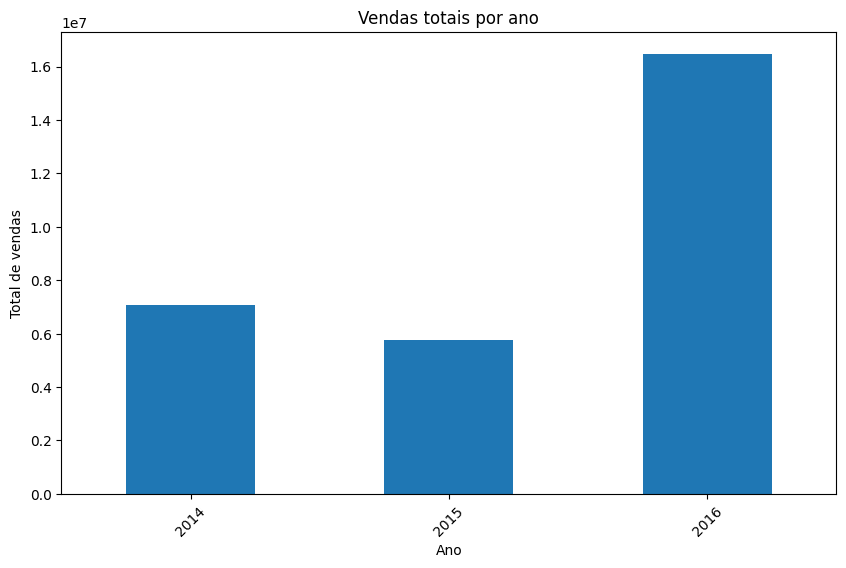

<Figure size 640x480 with 0 Axes>

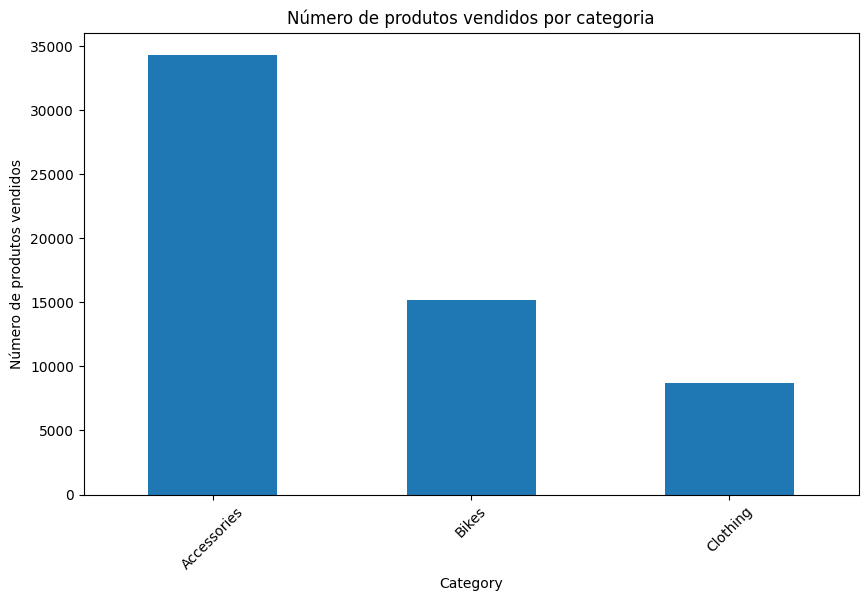

<Figure size 640x480 with 0 Axes>

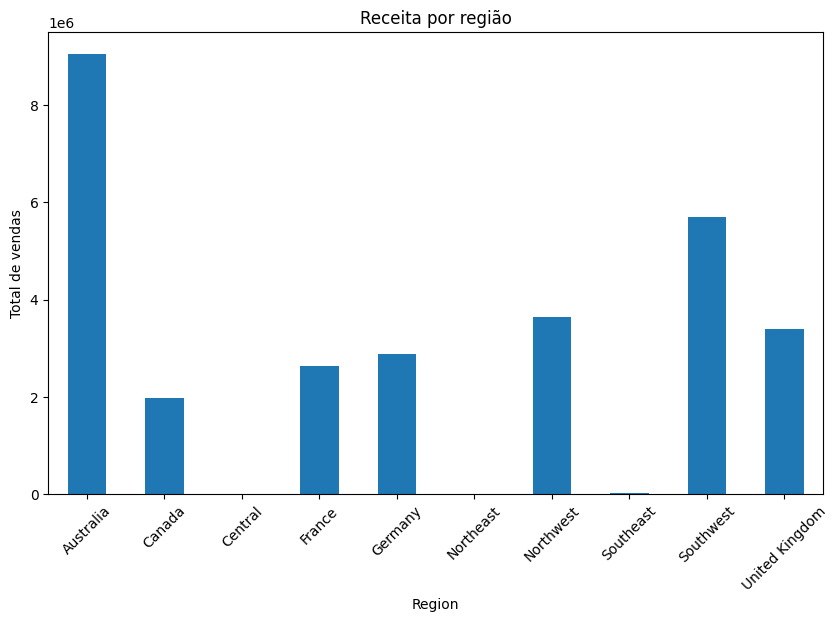

<Figure size 640x480 with 0 Axes>

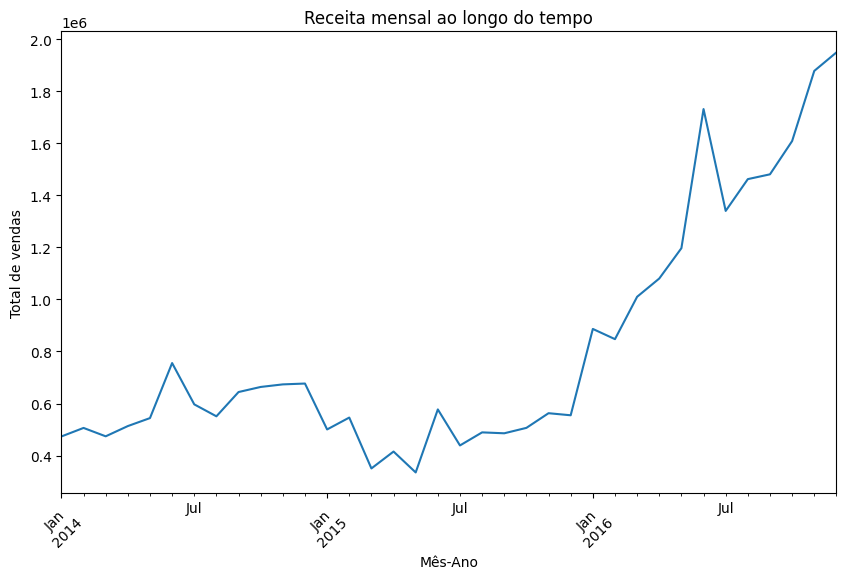

<Figure size 640x480 with 0 Axes>

In [14]:
# Exemplo 1: Vendas totais por ano
sales_by_year = merged_df.groupby(merged_df['OrderDate'].dt.year)['SalesAmount'].sum()
plt.figure(figsize=(10, 6))
sales_by_year.plot(kind='bar')
plt.title('Vendas totais por ano')
plt.xlabel('Ano')
plt.ylabel('Total de vendas')
plt.xticks(rotation=45)
plt.show()
plt.tight_layout()
print("\n\n")
# Exemplo 2: Número de produtos vendidos por categoria
products_by_category = merged_df['Category'].value_counts()
plt.figure(figsize=(10, 6))
products_by_category.plot(kind='bar')
plt.title('Número de produtos vendidos por categoria')
plt.xlabel('Category')
plt.ylabel('Número de produtos vendidos')
plt.xticks(rotation=45)
plt.show()
plt.tight_layout()
print("\n\n")
# Exemplo 3: Receita por região
revenue_by_region = merged_df.groupby('Region')['SalesAmount'].sum()
plt.figure(figsize=(10, 6))
revenue_by_region.plot(kind='bar')
plt.title('Receita por região')
plt.xlabel('Region')
plt.ylabel('Total de vendas')
plt.xticks(rotation=45)
plt.show()
plt.tight_layout()
print("\n\n")
# Exemplo 4: Receita mensal ao longo do tempo
revenue_by_month = merged_df.groupby(merged_df['OrderDate'].dt.to_period('M'))['SalesAmount'].sum()
plt.figure(figsize=(10, 6))
revenue_by_month.plot(kind='line')
plt.title('Receita mensal ao longo do tempo')
plt.xlabel('Mês-Ano')
plt.ylabel('Total de vendas')
plt.xticks(rotation=45)
plt.show()
plt.tight_layout()
print("\n\n")

# Questão 6: Total de vendas e o lucro total por ano e por região

In [15]:
# Criar uma cópia do DataFrame sales
sales_df = sales.copy()

# Garantir que TotalProductCost é string
sales_df['TotalProductCost'] = sales_df['TotalProductCost'].astype(str)

# Substituir vírgulas por pontos no TotalProductCost
sales_df['TotalProductCost'] = sales_df['TotalProductCost'].str.replace(',', '.')

# Converter TotalProductCost para numérico
sales_df['TotalProductCost'] = pd.to_numeric(sales_df['TotalProductCost'], errors='coerce')

# Verificar novamente os tipos de dados e valores únicos
print(sales_df.dtypes)
unique_total_product_cost_cleaned = sales_df['TotalProductCost'].unique()
print(unique_total_product_cost_cleaned)

# Atualizar a coluna TotalProductCost no DataFrame mesclado
merged_df['TotalProductCost'] = sales_df['TotalProductCost']

# Garantir que SalesAmount e TotalProductCost são numéricos
merged_df['SalesAmount'] = pd.to_numeric(merged_df['SalesAmount'], errors='coerce')
merged_df['TotalProductCost'] = pd.to_numeric(merged_df['TotalProductCost'], errors='coerce')

# Calcular lucro
merged_df['Profit'] = merged_df['SalesAmount'] - merged_df['TotalProductCost']

# Agrupar por ano e região
sales_profit_by_year_region = merged_df.groupby([merged_df['OrderDate'].dt.year, 'Region']).agg({
    'SalesAmount': 'sum',
    'Profit': 'sum'
}).reset_index()

# Renomear colunas para melhor interpretação
sales_profit_by_year_region.rename(columns={'OrderDate': 'Year'}, inplace=True)

# Formatar os valores de SalesAmount e Profit para exibição
sales_profit_by_year_region['SalesAmount'] = sales_profit_by_year_region['SalesAmount'].apply(lambda x: f'{x:,.2f}')
sales_profit_by_year_region['Profit'] = sales_profit_by_year_region['Profit'].apply(lambda x: f'{x:,.2f}')

# Exibir o DataFrame formatado como tabela em Jupyter Notebook ou similar
display(HTML(sales_profit_by_year_region.to_html(index=False)))


ProductID                        int64
OrderDate               datetime64[ns]
ShipDate                        object
CustomerID                       int64
PromotionKey                     int64
TerritoryID                      int64
SalesOrderNumber                object
SalesOrderLineNumber             int64
OrderQuantity                    int64
UnitPrice                      float64
TotalProductCost               float64
SalesAmount                    float64
TaxAmt                         float64
Unnamed: 15                    float64
Unnamed: 16                    float64
Unnamed: 18                    float64
ListPrice                      float64
StandardCost                   float64
dtype: object
[2.1712942e+03 1.9121544e+03 4.1314630e+02 1.8980944e+03 6.0564920e+02
 1.3206838e+03 4.8670660e+02 1.1058100e+03 1.1178559e+03 1.5187864e+03
 1.5549479e+03 3.3623000e+00 7.5515080e+02 1.3086300e+01 1.2656195e+03
 3.7363000e+00 1.8663000e+00 1.2192400e+01 1.4923000e+00 5.9466000e+01


Year,Region,SalesAmount,Profit
2014,Australia,"2,568,701.39","1,040,547.10"
2014,Canada,"573,100.97","228,167.88"
2014,France,"414,245.32","166,216.91"
2014,Germany,"513,353.17","206,706.78"
2014,Northwest,"925,831.84","369,830.13"
2014,Southwest,"1,526,344.23","609,693.65"
2014,United Kingdom,"550,507.33","221,993.12"
2015,Australia,"2,099,585.43","879,949.40"
2015,Canada,"305,010.69","125,668.33"
2015,Central,"2,071.42",953.56


C:\Users\Erick Bryan\AppData\Local\Temp\ipykernel_24504\2764294678.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax1 = sns.barplot(x='SalesAmount', y='Year', hue='Region', data=sales_profit_by_year_region, ci=None, orient='h')


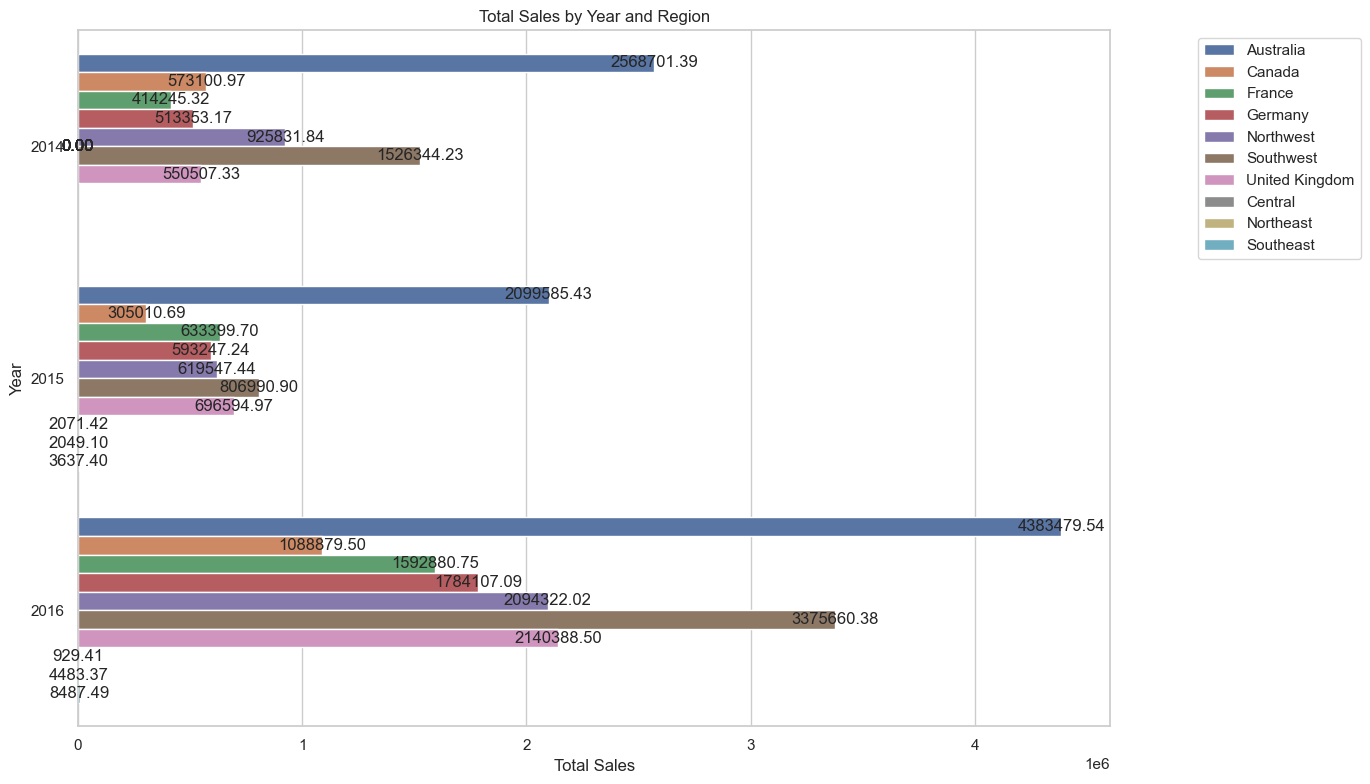

C:\Users\Erick Bryan\AppData\Local\Temp\ipykernel_24504\2764294678.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax2 = sns.barplot(x='Profit', y='Year', hue='Region', data=sales_profit_by_year_region, ci=None, orient='h')


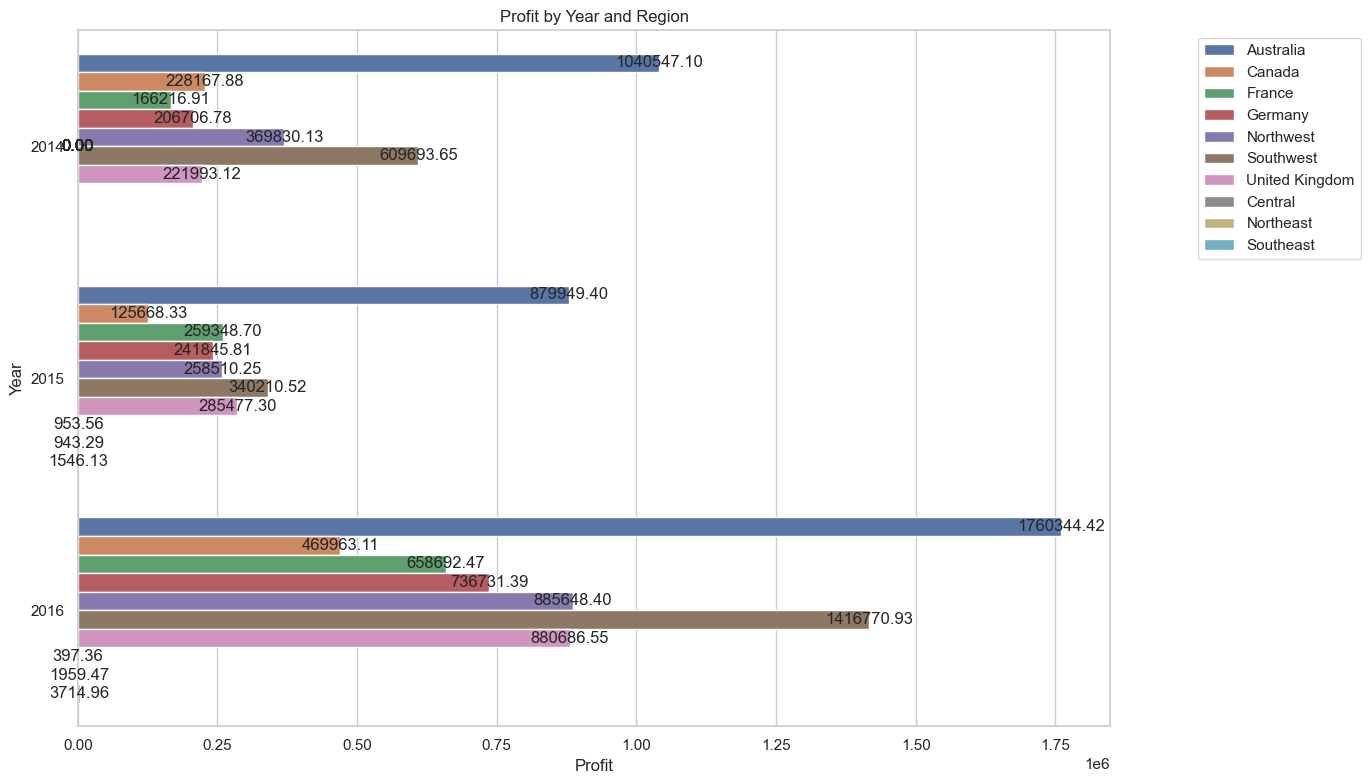

In [16]:
# Reverter a formatação das colunas para garantir que os valores são numéricos
sales_profit_by_year_region['SalesAmount'] = sales_profit_by_year_region['SalesAmount'].str.replace(',', '').astype(float)
sales_profit_by_year_region['Profit'] = sales_profit_by_year_region['Profit'].str.replace(',', '').astype(float)

# Configurar o estilo dos gráficos
sns.set(style="whitegrid")

# Exemplo 1: Total de Vendas por Ano e Região (Barras Horizontais)
plt.figure(figsize=(14, 8))
ax1 = sns.barplot(x='SalesAmount', y='Year', hue='Region', data=sales_profit_by_year_region, ci=None, orient='h')
plt.title('Total Sales by Year and Region')
plt.xlabel('Total Sales')
plt.ylabel('Year')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

# Adicionar valores no topo das barras
for p in ax1.patches:
    width = p.get_width()
    plt.text(width + 0.05, 
             p.get_y() + p.get_height() / 2, 
             '{:1.2f}'.format(width), 
             ha='center', 
             va='center')

plt.tight_layout()
plt.show()

# Exemplo 2: Lucro por Ano e Região (Barras Horizontais)
plt.figure(figsize=(14, 8))
ax2 = sns.barplot(x='Profit', y='Year', hue='Region', data=sales_profit_by_year_region, ci=None, orient='h')
plt.title('Profit by Year and Region')
plt.xlabel('Profit')
plt.ylabel('Year')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

# Adicionar valores no topo das barras
for p in ax2.patches:
    width = p.get_width()
    plt.text(width + 0.05, 
             p.get_y() + p.get_height() / 2, 
             '{:1.2f}'.format(width), 
             ha='center', 
             va='center')
plt.tight_layout()
plt.show()

# Questão 7 - Coluna classificação de clientes (alto, médio e baixo) baseado no lucro total gerado

In [17]:
# Carregar os dados novamente se necessário
sales_df = sales

# Garantir que SalesAmount e TotalProductCost são numéricos
sales_df['SalesAmount'] = pd.to_numeric(sales_df['SalesAmount'], errors='coerce')
sales_df['TotalProductCost'] = pd.to_numeric(sales_df['TotalProductCost'], errors='coerce')

# Calcular lucro por linha
sales_df['Profit'] = sales_df['SalesAmount'] - sales_df['TotalProductCost']

# Calcular lucro total por cliente
profit_by_customer = sales_df.groupby('CustomerID')['Profit'].sum().reset_index()

# Classificar clientes em segmentos de alta, média e baixa lucratividade
profit_by_customer['Segment'] = pd.qcut(profit_by_customer['Profit'], 
                                        q=3, 
                                        labels=['Baixa Lucratividade', 'Média Lucratividade', 'Alta Lucratividade'])

# Mapear a classificação de volta para a tabela Sales
sales_df = sales_df.merge(profit_by_customer[['CustomerID', 'Segment']], on='CustomerID', how='left')

# Verificar as primeiras e últimas entradas da tabela Sales com a nova coluna de classificação
display(HTML(sales_df.head().to_html(index=False)))
display(HTML(sales_df.tail().to_html(index=False)))

# Exibir a distribuição dos segmentos
segment_distribution = sales_df['Segment'].value_counts()
print(segment_distribution)

ProductID,OrderDate,ShipDate,CustomerID,PromotionKey,TerritoryID,SalesOrderNumber,SalesOrderLineNumber,OrderQuantity,UnitPrice,TotalProductCost,SalesAmount,TaxAmt,Unnamed: 15,Unnamed: 16,Unnamed: 18,ListPrice,StandardCost,Profit,Segment
310,2014-01-01,1/8/14 0:00,21768,1,6,SO43697,1,2,1789.1350,2171.2942,3578.2700,286.2616,3578.2700,0.0,-764.3184,3578.2700,2171.2942,1406.9758,Alta Lucratividade
346,2014-01-01,1/8/14 0:00,28389,1,7,SO43698,1,2,1699.9950,1912.1544,3399.9900,271.9992,3399.9900,0.0,-424.3188,3399.9900,1912.1544,1487.8356,Alta Lucratividade
346,2014-01-01,1/8/14 0:00,25863,1,1,SO43699,1,2,1699.9950,1912.1544,3399.9900,271.9992,3399.9900,0.0,-424.3188,3399.9900,1912.1544,1487.8356,Alta Lucratividade
336,2014-01-01,1/8/14 0:00,14501,1,4,SO43700,1,2,349.5491,413.1463,699.0982,55.9279,699.0982,0.0,-127.1944,699.0982,413.1463,285.9519,Alta Lucratividade
346,2014-01-01,1/8/14 0:00,11003,1,9,SO43701,1,2,1699.9950,1912.1544,3399.9900,271.9992,3399.9900,0.0,-424.3188,3399.9900,1912.1544,1487.8356,Alta Lucratividade


ProductID,OrderDate,ShipDate,CustomerID,PromotionKey,TerritoryID,SalesOrderNumber,SalesOrderLineNumber,OrderQuantity,UnitPrice,TotalProductCost,SalesAmount,TaxAmt,Unnamed: 15,Unnamed: 16,Unnamed: 18,ListPrice,StandardCost,Profit,Segment
561,2016-12-30,1/7/17 0:00,13650,1,9,SO74145,1,1,2384.07,1481.9379,2384.07,190.7256,2384.07,0.0,902.1321,2384.07,1481.9379,902.1321,Alta Lucratividade
584,2016-12-30,1/7/17 0:00,26916,1,9,SO74146,1,1,539.99,343.6496,539.99,43.1992,539.99,0.0,196.3404,539.99,343.6496,196.3404,Média Lucratividade
605,2016-12-30,1/7/17 0:00,27473,1,9,SO74147,1,1,539.99,343.6496,539.99,43.1992,539.99,0.0,196.3404,539.99,343.6496,196.3404,Média Lucratividade
538,2016-12-30,1/7/17 0:00,27473,1,9,SO74147,2,1,21.49,8.0373,21.49,1.7192,21.49,0.0,13.4527,21.49,8.0373,13.4527,Média Lucratividade
490,2016-12-30,1/7/17 0:00,27473,1,9,SO74147,3,1,53.99,41.5723,53.99,4.3192,53.99,0.0,12.4177,53.99,41.5723,12.4177,Média Lucratividade


Segment
Alta Lucratividade     23759
Média Lucratividade    21235
Baixa Lucratividade    13195
Name: count, dtype: int64


# Questão 8 - Impacto da lucaritvidade com o desconto médio reduzido em 10%
Inicialmente tive de identificar qual seria a coluna de desconto, visualizei os campos e os respectivos tipos de dados, em seguida com describre visualizei a média dos descontos. Com isso, trabalhei com a suposição de que a coluna "*Unnamed: 18*" poderia representar descontos, dado que contém valores negativos que podem indicar reduções de preço. Logo, utilizei esta coluna para calcular o impacto no lucro ao reduzir o desconto médio em 10%.

Os resultados indicam o impacto no lucro ao reduzir o desconto médio em 10%:
- Lucro atual total: -4,681,309,288.94
- Novo lucro total: 13,903,267,386.51
- Impacto no lucro: 18,584,576,675.45

O lucro atual total é negativo, o que indica que a empresa está tendo prejuízo. Ao reduzir o desconto médio em 10%, o novo lucro total seria positivo, indicando um aumento significativo no lucro. Portanto, a redução do desconto médio pode ter um impacto positivo na lucratividade da empresa.

In [18]:
column_types = [(column, sales[column].dtype) for column in sales.columns]
df_column_types = pd.DataFrame(column_types, columns=["Nome da Coluna", "Tipo de Dado"])
display(HTML(df_column_types.to_html(index=False)))    

Nome da Coluna,Tipo de Dado
ProductID,int64
OrderDate,datetime64[ns]
ShipDate,object
CustomerID,int64
PromotionKey,int64
TerritoryID,int64
SalesOrderNumber,object
SalesOrderLineNumber,int64
OrderQuantity,int64
UnitPrice,float64


In [19]:
# Verificar os dados após a conversão
sales_df[columns_to_convert].describe()

,UnitPrice,TotalProductCost,SalesAmount,TaxAmt,Unnamed: 15,Unnamed: 16,Unnamed: 18,ListPrice,StandardCost
count,58189.000000,58189.000000,58189.000000,58189.000000,58189.000000,58189.000000,58189.000000,58189.000000,58189.000000
mean,413.888218,296.539185,503.666270,40.293303,503.666269,0.000001,38.398254,503.666270,296.539185
std,833.052938,560.171436,941.462817,75.317027,941.462815,0.000014,667.349417,941.462817,560.171436
min,0.572500,0.856500,2.290000,0.183200,2.290000,0.000000,-5106.906800,2.290000,0.856500
25%,4.990000,3.362300,8.990000,0.719200,8.990000,0.000000,1.433500,8.990000,3.362300
50%,24.490000,12.192400,32.600000,2.608000,32.600000,0.000000,6.253700,32.600000,12.192400
75%,269.995000,343.649600,539.990000,43.199200,539.990000,0.000000,21.903700,539.990000,343.649600
max,3578.270000,2171.294200,3578.270000,286.261600,3578.270000,0.000300,1487.835600,3578.270000,2171.294200


In [20]:
# Carregar os dados
calendar_df = calendar
customers_df = customers
products_df = product
sales_df = sales
territory_df = territory

# Renomeie a coluna 'Unnamed: 18' para 'Discount'
sales_df.rename(columns={'Unnamed: 18': 'Discount'}, inplace=True)

# Calcular o lucro atual total
sales_df['Current_Profit'] = sales_df['SalesAmount'] - (sales_df['Discount'] * sales_df['SalesAmount'])

# Calcular a média atual de desconto
current_avg_discount = sales_df['Discount'].mean()

# Reduzir o desconto médio em 10%
new_avg_discount = current_avg_discount * 0.90

# Ajustar os descontos
sales_df['New_Discount'] = sales_df['Discount'].apply(lambda x: x if x < new_avg_discount else new_avg_discount)

# Calcular o novo lucro total
sales_df['New_Profit'] = sales_df['SalesAmount'] - (sales_df['New_Discount'] * sales_df['SalesAmount'])

# Calcular o lucro total antes e depois do ajuste
current_total_profit = sales_df['Current_Profit'].sum()
new_total_profit = sales_df['New_Profit'].sum()

# Comparar os resultados
impact_on_profit = new_total_profit - current_total_profit

# Formatar os resultados
formatted_current_total_profit = f'{current_total_profit:,.2f}'
formatted_new_total_profit = f'{new_total_profit:,.2f}'
formatted_impact_on_profit = f'{impact_on_profit:,.2f}'

print(f'Lucro atual total: {formatted_current_total_profit}')
print(f'Novo lucro total: {formatted_new_total_profit}')
print(f'Impacto no lucro ao reduzir o desconto médio em 10%: {formatted_impact_on_profit}')



Lucro atual total: -4,681,309,288.94
Novo lucro total: 13,903,267,386.51
Impacto no lucro ao reduzir o desconto médio em 10%: 18,584,576,675.45


# Questão 9 - Modelagem preditiva para prever as vendas futuras
Com base nos resultados da modelagem preditiva utilizando regressão Ridge, o modelo alcançou um MSE de aproximadamente R$195.720.910.979,08, um MAE de aproximadamente R$126.181,15, e um R² de 0,92 no conjunto de teste, indicando que o modelo explica 92% da variação nos dados de teste. O R² médio na validação cruzada foi de 0,87, demonstrando uma boa capacidade de generalização. A diferença média entre o lucro previsto e o lucro atual foi de aproximadamente R$319.867,07, sugerindo um aumento substancial na lucratividade futura das vendas.

MSE: 195720910979.08
MAE: 126181.15
R^2: 0.92
R^2 médio na validação cruzada: 0.87


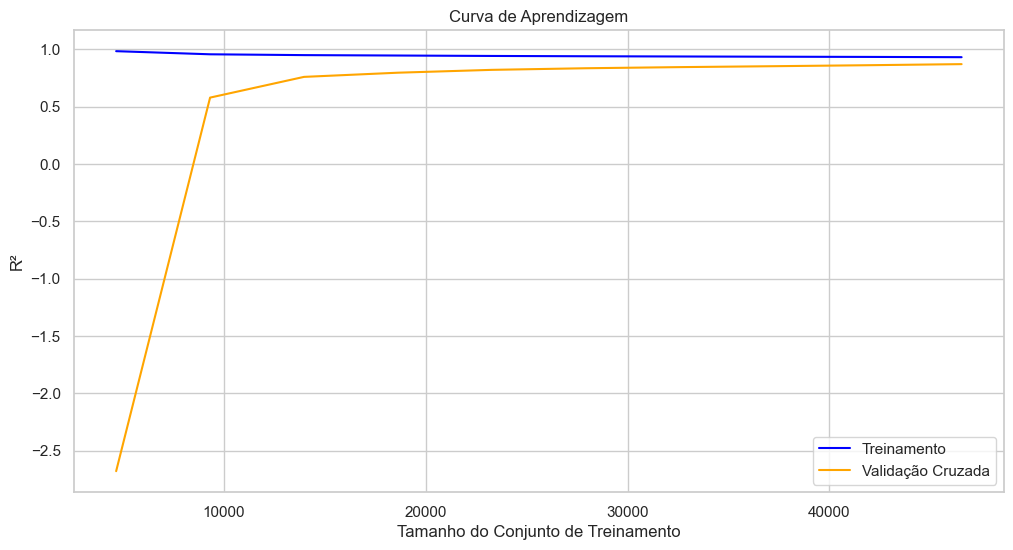

Diferença média entre Lucro Previsto e Lucro Atual: 319867.07


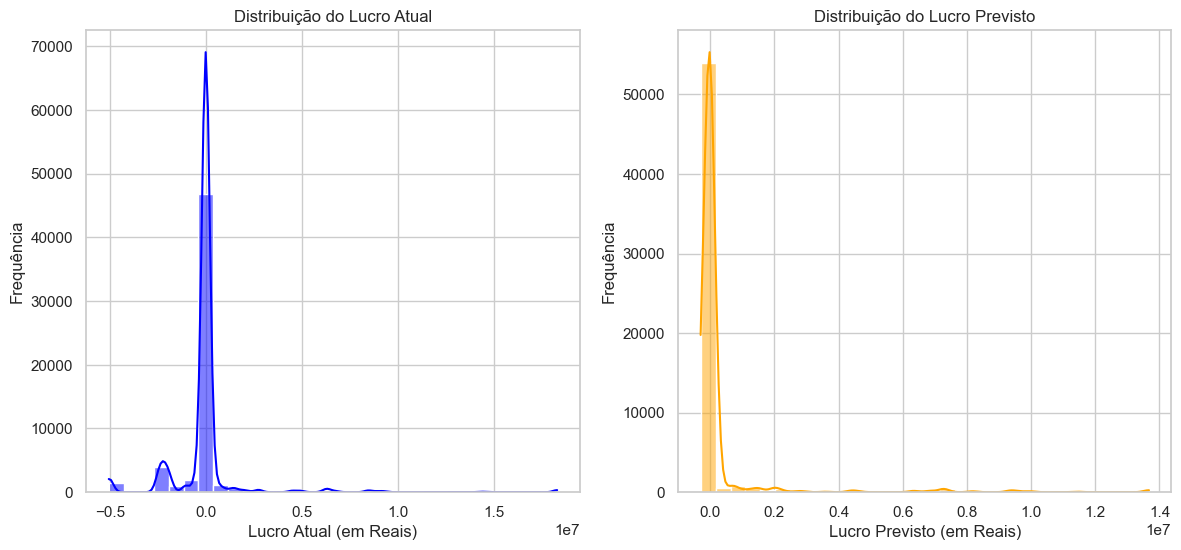

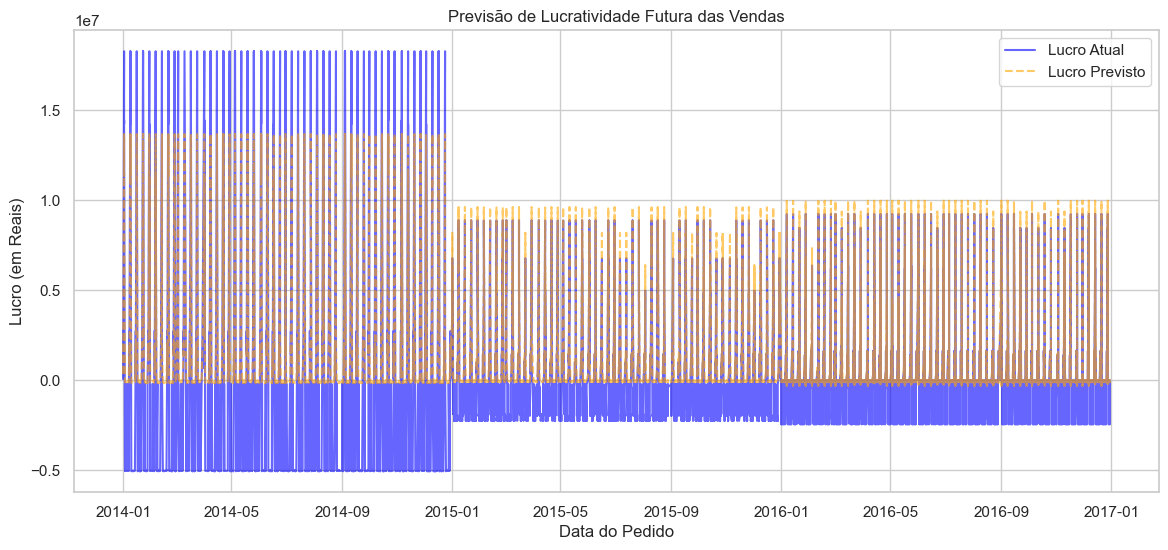

In [21]:
# Selecionar variáveis relevantes com base na análise de correlação
relevant_features = ['SalesAmount', 'Discount', 'OrderQuantity', 'UnitPrice', 'TotalProductCost', 'TaxAmt', 'ListPrice', 'StandardCost']
target = 'New_Profit'

X = sales_df[relevant_features]
y = sales_df[target]

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construir o modelo de regressão linear com regularização Ridge
model = make_pipeline(StandardScaler(), Ridge())

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Calcular as métricas de avaliação
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R^2: {r2:.2f}')

# Validar o modelo usando validação cruzada
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f'R^2 médio na validação cruzada: {cv_scores.mean():.2f}')

# Curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_scores_mean, label='Treinamento', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Validação Cruzada', color='orange')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('R²')
plt.title('Curva de Aprendizagem')
plt.legend()
plt.show()

# Fazer previsões no conjunto de dados original
sales_df['Predicted_New_Profit'] = model.predict(X)

# Verificar a diferença entre lucros previstos e atuais
profit_diff = sales_df['Predicted_New_Profit'] - sales_df['Current_Profit']
print(f'Diferença média entre Lucro Previsto e Lucro Atual: {profit_diff.mean():.2f}')

# Visualizar a distribuição dos lucros atuais e previstos
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(sales_df['Current_Profit'], kde=True, color='blue', bins=30)
plt.title('Distribuição do Lucro Atual')
plt.xlabel('Lucro Atual (em Reais)')
plt.ylabel('Frequência')

plt.subplot(1, 2, 2)
sns.histplot(sales_df['Predicted_New_Profit'], kde=True, color='orange', bins=30)
plt.title('Distribuição do Lucro Previsto')
plt.xlabel('Lucro Previsto (em Reais)')
plt.ylabel('Frequência')

plt.show()

# Visualizar a lucratividade futura das vendas
plt.figure(figsize=(14, 6))
plt.plot(sales_df['OrderDate'], sales_df['Current_Profit'], label='Lucro Atual', color='blue', alpha=0.6)
plt.plot(sales_df['OrderDate'], sales_df['Predicted_New_Profit'], label='Lucro Previsto', color='orange', linestyle='--', alpha=0.6)
plt.xlabel('Data do Pedido')
plt.ylabel('Lucro (em Reais)')
plt.title('Previsão de Lucratividade Futura das Vendas')
plt.legend()
plt.show()
